Michael Ricardo DS 2500 Project Treasure Hunter

In [73]:
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [74]:
def fetch_ticker_data(ticker):
    """
    Gets the market data for a given date and ticker.
    Fetches from yfinance library.

    Args:
        years ago (int): Representing the most recent day for stock entries 
        ticker(str): Representing the offical company stock ticker
    Returns
        df (DataFrame): DataFrame with Stock pricing data and history data
    """
    most_recent = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
    start_date = '2014-12-01'
    
    
    stock_data = yf.Ticker(ticker)
    returning_data = stock_data.history(start = start_date, end= most_recent)
    
    returning_data.index = returning_data.index.tz_localize(None).normalize()

    return returning_data

Addinng in Ten year, Thirteen Week, S&P 500 and VIX

In [75]:
#Data for the ITX, Thirteen Year
ticker = '^IRX'
Thirteen_Week = fetch_ticker_data(ticker)
Thirteen_Week = Thirteen_Week.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume', 'High', 'Low'])
Thirteen_Week = Thirteen_Week.rename(columns={'Close': '13_week_close'})

In [76]:
#Data for the TNX, Ten Year
ticker = '^TNX'
Ten_Year = fetch_ticker_data(ticker)
Ten_Year = Ten_Year.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume'])
Ten_Year = Ten_Year.rename(columns={'High': '10_year_high', 'Low': '10_year_low', 'Close': '10_year_close'})

In [77]:
#Data for the S&P 500 
ticker = '^GSPC'
SP500 = fetch_ticker_data(ticker)
SP500['SP500_SMA_14'] = ta.sma(SP500['Close'], length=14) 
SP500 = SP500.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

In [78]:
#VIX Data
ticker = '^VIX'
VIX = fetch_ticker_data(ticker)
VIX['VIX_SMA_14'] = ta.sma(VIX['Close'], length=14) 
VIX = VIX.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

Pulling external csv and prepping for merge

In [79]:
def external_csv(csv):
    '''
    Pulling in a csv, setting the 'Date column as the index and making it a proper datetime object
    Args:
        csv (CSV) - Data collection with Date column along with pricing data 
    Returns
        df (DataFrame): DataFrame     
    '''
    csv_read = pd.read_csv(csv)
    
    return csv_read

In [80]:
#CPI data CSV
cpi_csv = 'CPI_Data_10.csv'
cpi = external_csv(cpi_csv)
cpi = cpi.rename(columns={'Close': 'CPI_close'})
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi = cpi.set_index('Date')

In [81]:
#Makig CPI fill for all datafreame PLEASE FIX THIS
full_date_range = pd.date_range(start='2014-12-01', end="2024-11-27", freq='D')
cpi = cpi.reindex(full_date_range)
cpi = cpi.ffill()
cpi.index.name = 'Date'

In [82]:
#Performing PCA on S&P500 and CPI data 
SP500_cpi = pd.concat([SP500, cpi], axis=1).dropna()
index_saved = SP500_cpi.index
working_array = SP500_cpi.values
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(working_array)
SP500_cpi_data = pd.DataFrame(reduced_data, columns=['SP500', 'cpi'], index=index_saved)

SP500_cpi_data

,SP500,cpi
Date,,
2014-12-18,-1278.166074,-0.737457
2014-12-19,-1276.937117,-0.765757
2014-12-22,-1276.080916,-0.785473
2014-12-23,-1275.521075,-0.798365
2014-12-24,-1274.809838,-0.814743
...,...,...
2024-11-21,2601.060081,-10.844385
2024-11-22,2619.387358,-11.266421
2024-11-25,2633.998510,-11.602883


In [83]:
#One Year pullnig in CSV
one_year_csv = '1year_bond_master.csv'
One_Year = external_csv(one_year_csv)

In [84]:
#Further cleaning needed for the 1 year, flipping the rows, eliminating % sign within each
One_Year = One_Year.iloc[::-1] 
One_Year['Close'] = One_Year['Close'].str.rstrip('%').astype(float)
One_Year = One_Year.set_index('Date')

In [85]:
#Finding MACD and saving that as the DF, only saving MACDs for now since it is most relevant 
one_year_MACD = ta.macd(One_Year["Close"], fast=12, slow=26, signal=9)
One_Year = pd.concat([One_Year, one_year_MACD], axis=1)


In [86]:
One_Year = One_Year.drop(columns=['Open', 'High', 'Low', 'Close', 'MACD_12_26_9','MACDh_12_26_9'])

Editing existing 10_year col for analysis and finding short term spread

In [87]:
#Finding Yield Staterd deviation as a measure of the securities volatility
Ten_Year['Yield_STDEV'] = Ten_Year['Yield_STDEV'] = ta.stdev(Ten_Year['10_year_close'], length = 14)

In [88]:
#Finding the spread between Long and Short term bonds/bills with the thirtteen week, droppin uneeded cols
Ten_Year['Short_Term_Spread'] = Ten_Year['10_year_close'] - Thirteen_Week['13_week_close']

Ten_Year = Ten_Year.drop(columns=['10_year_low', '10_year_high'])

Combing existing Data frames

In [89]:

def combine(df_first, dfs):
    """
    Combining the data from other indexes to be used as variabels
    Args:
        df_main (dataframe): Main secuirty which will have the others cols added
        df_1 (dataframe): Sub index which will be added to df_main, will be used for S&P 500
        df_2 (dataframe): Sub index which will be added to df_main, will be used for VIx 
    Returns:
        df_mained: Combined df_main with df1 & df2
    """
    for df in dfs:
        # Ensure indices are aligned and consistent
        df.index = pd.to_datetime(df.index)
        df_first = pd.concat([df_first, df], axis=1)
    return df_first


In [ ]:
#merging the dfs from above into the 10 year bond
dfs = [VIX, One_Year, SP500_cpi_data]
df_first = Ten_Year
final_df = combine(df_first, dfs).dropna()

In [113]:
#Low correlation between variables as needed
final_df.corr()

,10_year_close,Yield_STDEV,Short_Term_Spread,VIX_SMA_14,MACDs_12_26_9,SP500,cpi
10_year_close,1.000000,0.312663,-0.583657,-0.287788,0.240258,0.482669,0.621296
Yield_STDEV,0.312663,1.000000,-0.247659,0.319031,0.052776,0.267369,0.437338
Short_Term_Spread,-0.583657,-0.247659,1.000000,0.014401,0.211145,-0.614071,-0.481886
VIX_SMA_14,-0.287788,0.319031,0.014401,1.000000,-0.108356,0.117466,0.089051
MACDs_12_26_9,0.240258,0.052776,0.211145,-0.108356,1.000000,0.054470,0.199648
SP500,0.482669,0.267369,-0.614071,0.117466,0.054470,1.000000,0.000984
cpi,0.621296,0.437338,-0.481886,0.089051,0.199648,0.000984,1.000000


Regressions:

In [92]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")
    return Xnew

In [93]:
from sklearn.metrics import mean_squared_error, r2_score
def linreg_predict(features, dependent, df):
    """Predicts vals for a given array, and returns dct of mse and r^2
    Args:
        Xnew: (an array, either 1-d or 2-d which includes all the $p$ predictor features, not including bias term)
        ynew: (a 1-d array which includes all corresponding response values to `Xnew`)
        m: (a 1-d array of length $p+1$ which contains the coefficients from the `line_of_best_fit` function)
    Returns:
        dct: dictionary, dct of mse and r^2 vals
    """

    features_df = df[features]
    target_series = df[dependent]
    X_train, X_test, y_train, y_test = train_test_split(features_df, target_series, random_state=30, test_size = 0.3)
    linear_regression_model = LinearRegression()
    linear_regression_model.fit(X_train, y_train)
    
    predictions = linear_regression_model.predict(X_test)
    rmse = np.sqrt(((predictions - y_test) ** 2).mean())
    
    residuals = y_test - predictions
    dct = {}
    
    
    dct["ypreds"] = predictions
    dct["resids"] = residuals
    dct["mse"] = rmse
    dct["r2"] = r2_score(y_test, dct["ypreds"])

    return dct

In [94]:
m = linreg_predict(features=['Yield_STDEV','Short_Term_Spread','VIX_SMA_14','MACDs_12_26_9','SP500','cpi'], dependent='10_year_close', df=final_df)

In [95]:
m

{'ypreds': array([ 3.19568503,  4.31523123,  1.93315301,  1.85752699,  4.10838433,
         2.33137499,  4.12635047,  2.34057983,  2.03666696,  2.08029161,
         2.28534484,  1.22340188,  1.14156422,  4.1189147 ,  2.15244758,
         2.08838194,  3.92763234,  4.0626888 ,  1.7957884 ,  2.01928447,
         3.53264581,  1.19061983,  3.10778117,  2.31591051,  1.30362463,
         4.11850977,  1.99878643,  2.31277381,  1.76327986,  4.04128326,
         1.93487618,  4.45013807,  3.89932634,  3.92174637,  1.95869669,
         2.25274675,  2.30711638,  4.12452751,  2.28134988,  2.22601361,
         2.28084608,  3.36410043,  2.24142867,  4.05414758,  1.25340413,
         4.52499047,  2.26434444,  2.19046387,  2.34602452,  4.5006785 ,
         4.14950243,  2.60109175,  2.3168323 ,  2.31227368,  1.40048925,
         1.29018615,  4.00607916,  2.35481097,  1.79806965,  1.73562146,
         2.95832938,  1.64179671,  1.98201724,  1.36281463,  4.10792107,
         2.04542904,  1.7103297 ,  2.2046

In [96]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

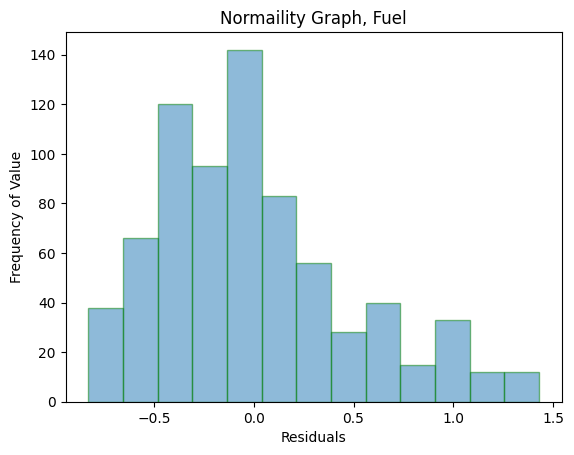

In [105]:
import matplotlib.pyplot as plt
plt.hist(Residuals_vals, bins=13, edgecolor='Green', alpha=0.5)
plt.title("Normaility Graph, Fuel")
plt.xlabel("Residuals")
plt.ylabel("Frequency of Value")
plt.show()

#Source for MACD
https://tradingstrategy.ai/docs/api/technical-analysis/momentum/help/pandas_ta.momentum.macd.html

#Data source for One-Year Treasury
https://www.marketwatch.com/investing/bond/tmubmusd01y/download-data?countrycode=bx&mod=mw_quote_tab 

#Yfinance
https://pypi.org/project/yfinance/

#CPI
https://fred.stlouisfed.org/series/CPIAUCSL